# basic set up

In [1]:
#basic set up
%matplotlib inline
import logging
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import os
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from IPython.display import clear_output
from matplotlib.path import Path
import pandas as pd
import pdb
from logzero import logger

logging.getLogger('matplotlib').setLevel(logging.WARNING)


#netflow 
import ets_fiber_assigner.netflow as nf
import ets_fiber_assigner.io_helpers as io_helpers
from ics.cobraOps.Bench import Bench
from ics.cobraOps.TargetGroup import TargetGroup
from ics.cobraOps.CobrasCalibrationProduct import CobrasCalibrationProduct
from ics.cobraOps.BlackDotsCalibrationProduct import BlackDotsCalibrationProduct
from pfs.utils.fiberids import FiberIds

from ics.cobraCharmer.pfiDesign import PFIDesign
from ics.cobraCharmer.cobraCoach.cobraCoach import CobraCoach
from ics.cobraOps.DistanceTargetSelector import DistanceTargetSelector

from ics.cobraOps.CollisionSimulator2 import CollisionSimulator2
from ics.cobraOps.CollisionSimulator import CollisionSimulator
from ics.cobraOps.cobraConstants import NULL_TARGET_POSITION, NULL_TARGET_ID
from ics.cobraOps import plotUtils
from collections import defaultdict


'''
Common imports for the project
'''
# io 
from astropy.table import Table, column
from astropy.io import fits, ascii

# plot 
import matplotlib as mpl
from matplotlib import rc

# Set default font properties
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'size': 20})
rc('text', **{'usetex':'False'})
rc('axes', **{'grid':'True','labelsize':24,'linewidth':1.5,})
rc('xtick',**{'direction':'in','labelsize':20,'minor.visible':True,'major.size': 10,'major.width': 1.5, \
              'minor.size': 3.72,'major.width': 0.8})
rc('ytick',**{'direction':'in','labelsize':20,'minor.visible':True,'major.size': 10,'major.width': 1.5, \
              'minor.size': 3.72,'major.width': 0.8})
rc('legend',**{'frameon':False,'numpoints':1,'scatterpoints':1,'fontsize':18})
rc('figure',**{'autolayout':True})
rc('grid',**{'alpha':0.6,'linewidth':0.8,'linestyle':'--'})

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
new_colors = [mpl.colors.to_rgba(color_i) for color_i in new_colors]

# key functions

In [2]:
# read the pointing centers from the file
def read_pointings(file):
    """
    Read pre-defined pointings from a file
    """
    try:
        # first try reading as ecsv format
        t = Table.read(file, format="ascii.ecsv")
        return t["R.A."], t['Dec.']
    except:
        pass

    with open(file) as f:
        ras = []
        decs = []
        ll = f.readlines()
        for l in ll[1:]:
            if not l.startswith("#"):
                tt = l.split()
                ra, dec = (float(tt[0]), float(tt[1]))
                ras.append(ra)
                decs.append(dec)
    return np.array(ras), np.array(decs)

# TODO: try a more efficient way to contruct the target list, add alreadyObserved to the target list either in netflow Targets or in this function
def construct_tgt_list(catalog_path = "../proc_data/", \
                       fn_list = ["cos_select.ecsv", "star_select.ecsv", "sky_select.ecsv"], \
                       prefix_list = ["sci", "cal", "sky"], calibration_list = [False, True, True]):
    '''
    Construct target list
    '''
    print("construct target list:")
    for i, fn_i in enumerate(fn_list):
        fn = catalog_path + fn_i
        print(fn)
        
        # read all targets into a single list, giving them their proper types
        if(i<1):
            if(not calibration_list[i]): tgt = nf.readScientificFromFile(fn, prefix_list[i])
            if(calibration_list[i]): tgt = nf.readCalibrationFromFile(fn, prefix_list[i])
        else:
            if(not calibration_list[i]): tgt += nf.readScientificFromFile(fn, prefix_list[i])
            if(calibration_list[i]): tgt += nf.readCalibrationFromFile(fn, prefix_list[i])

    print("In total, there are %d targets." % len(tgt))

    # sample of sci targets
    sample_sci = []
    for t in tgt:
        if(t.targetclass[:3] == 'sci'): sample_sci.append([t.ID,t.ra,t.dec])  

    sample_sci = np.array(sample_sci)
    
    return tgt, sample_sci

# TODO: play with the cost value for different classes
def def_classdict():
    '''define classdict for netflow run
    
    Parameters
    ==========
    None
    
    Returns
    =======
    classdict
    '''
    # create the dictionary containing the costs and constraints for all classes
    # of targets
    classdict = {}
    classdict["sci_P1"] = {"nonObservationCost": 400,
                           "partialObservationCost": 1e6, "calib": False}
    classdict["sci_P2"] = {"nonObservationCost": 200,
                           "partialObservationCost": 1e6, "calib": False}
    classdict["sci_P3"] = {"nonObservationCost": 100,
                           "partialObservationCost": 1e6, "calib": False}
    
    #for ancillary targets
    classdict["anc_P1"] = {"nonObservationCost": 50,
                           "partialObservationCost": 1e6, "calib": False}
    classdict["anc_P2"] = {"nonObservationCost": 10,
                           "partialObservationCost": 1e6, "calib": False}
    
    '''
    #need to ask PFS project office to get the "numRequired"
    classdict["sky"] = {"numRequired": 400,
                        "nonObservationCost": 1e6, "calib": True}
    #100-200 stars - Masayuki
    classdict["cal"] = {"numRequired": 200,
                        "nonObservationCost": 1e6, "calib": True}
    '''

    return classdict



def write_output(tgt, res, tpos, telescopes, fdir_out, fn_out, t_obs=900):
    '''write the output of fiber assignment
    Parameters
    ==========
    fdir_out: string
        output folder directory
    fn_out: string
        output file name
    '''
    
    with open(fdir_out + fn_out, "w") as f:
        for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
            print("exposure {}:".format(i))
            print("  assigned Cobras: {}".format(len(vis)))
            tdict = defaultdict(int)
            f.write("# Exposure {}: duration {}s, RA: {}, Dec: {}, PA: {}\n".
                    format(i+1, t_obs, tel._ra, tel._dec, tel._posang))
            f.write("# Target    Fiber          X          Y         "
                    "RA        DEC\n")
            for tidx, cidx in vis.items():
                tdict[tgt[tidx].targetclass] += 1 #tgt[].targetclass = 'sci_Px'
                f.write("{:} {:6d} {:10.5f} {:10.5f} {:10.5f} {:10.5f}\n"
                        .format(tgt[tidx].ID, cidx+1, tp[tidx].real, tp[tidx].imag,
                                tgt[tidx].ra, tgt[tidx].dec))
            for cls, num in tdict.items():
                print("   {}: {}".format(cls, num))
                
                
def cal_completeness(tgt, res, tpos, telescopes, Plot=False, fn_fig='', Save=False, fn_fibeff=''):
    '''calculate the completeness of the targets and fiber assignment fraction
    Parameters
    ==========
    fdir_out: string
        output folder directory
    Plot: boolean
        plot the results if True 
    '''
    
    #fiber assignment fraction of each pointing
    fib_eff = [] 
    #fiber assignment fraction of pointing which observed galaxies
    fib_eff_gal = []
    fib_eff_anc = []
    #calibration targets
    fib_eff_star = []
    fib_eff_sky = []

    #objects that got allocated a fiber
    obj_allo = []
    for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
        fib_eff_t = len(vis)/2394.*100 #2394 fibers available
        fib_eff.append(fib_eff_t)

        n_fib_gal = 0
        n_fib_anc = 0
        n_fib_star = 0
        n_fib_sky = 0
        #tidx is the id in tgt list; cidx is the fiber id, starting from 0
        for tidx, cidx in vis.items():
            obj_allo.append(["Point_"+str(i+1), tel._ra, tel._dec, tel._posang, tgt[tidx].ID,
                            cidx+1, tp[tidx].real, tgt[tidx].ra, tgt[tidx].dec,
                            tgt[tidx].targetclass])

            if tgt[tidx].targetclass[:3]=='sci': n_fib_gal+=1
            if tgt[tidx].targetclass[:3]=='anc': n_fib_anc+=1
            if tgt[tidx].targetclass[:3]=='sky': n_fib_sky+=1
            if tgt[tidx].targetclass[:3]=='cal': n_fib_star+=1

        fib_eff_gal.append(n_fib_gal/2394.*100)
        fib_eff_anc.append(n_fib_anc/2394.*100)
        fib_eff_star.append(n_fib_star/2394.*100)
        fib_eff_sky.append(n_fib_sky/2394.*100)

        print("exposure {}:".format(i))
        print("assigned Cobras(%): {:.2f}%; gal--{:.2f}%, anc--{:.2f}%, sky--{:.2f}%, star--{:.2f}%". format(fib_eff[i], fib_eff_gal[i], fib_eff_anc[i], fib_eff_sky[i], fib_eff_star[i]))
    
    if(Save==True):
        np.savetxt(fn_fibeff, np.c_[fib_eff, fib_eff_gal, fib_eff_anc, fib_eff_sky, fib_eff_star])
    
    #unique tgt_class
    tgt_class = []
    for tgt_i in tgt:
        tgt_class.append(tgt_i.targetclass)
    tgt_class = np.array(tgt_class)
    uniq_tgt_class = np.unique(tgt_class)

    #completeness fraction
    tgt_class_allo = np.array([obj_allo_i[-1] for obj_allo_i in obj_allo])
    comp_out = {}
    for ii, uniq_tgt_i in enumerate(uniq_tgt_class):
        mask_i = tgt_class == uniq_tgt_i
        tot = len(tgt_class[mask_i])

        mask_ii = tgt_class_allo == uniq_tgt_i
        done = len(tgt_class_allo[mask_ii])

        comp_out[uniq_tgt_i] = done/tot
        
    print("comp_out=", comp_out)
    
    #plot
    if(Plot==True):  
        npoint_used = len(tpos)
        msk_sci_class =  [uniq_tgt_class_i[:3]=='sci' for uniq_tgt_class_i in uniq_tgt_class]
        sci_class = uniq_tgt_class[msk_sci_class]
        msk_anc_class =  [uniq_tgt_class_i[:3]=='anc' for uniq_tgt_class_i in uniq_tgt_class]
        sci_class = np.append(sci_class, uniq_tgt_class[msk_anc_class])
        print(sci_class)
        
        plt.figure(figsize=(12, 4))
        plt.subplot(121)
        for ii, sci_class_ii in enumerate(sci_class):
            plt.bar([ii+1], comp_out[sci_class_ii], width=1., fc='tomato', ec='none', alpha=0.8, zorder=10)
            plt.bar([ii+1], comp_out[sci_class_ii], width=1., ec='tomato', fc='none', lw=1)

        plt.plot([0,10], [0.8,0.8], 'k--', lw=2, zorder=11)
        plt.xticks(np.arange(len(sci_class))+1, sci_class, fontsize=15)
        plt.ylabel('completeness fraction', fontsize=15)
        plt.xlim(0, len(sci_class)+2)
        plt.ylim(0, 1.)

        plt.subplot(122)
        plt.bar(np.arange(0,len(fib_eff_gal),1), fib_eff_gal, width=0.8, fc='tomato', ec='none', alpha=0.6, zorder=10)
        plt.bar(np.arange(0,len(fib_eff_anc),1), fib_eff_anc, width=0.8, fc='purple', ec='none', alpha=0.5)
        plt.bar(np.arange(0,len(fib_eff_sky),1), fib_eff_sky, width=0.8, fc='blue', ec='none', alpha=0.5)
        plt.bar(np.arange(0,len(fib_eff_star),1), fib_eff_star, width=0.8, fc='gray', ec='none', alpha=0.5)

        plt.plot([0,npoint_used+1.], [80,80], 'k--', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_gal), np.mean(fib_eff_gal)], '--', color='tomato', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_anc), np.mean(fib_eff_anc)], '--', color='purple', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_sky), np.mean(fib_eff_sky)], '--', color='blue', lw=2, zorder=11)
        plt.plot([0,npoint_used+1.], [np.mean(fib_eff_star), np.mean(fib_eff_star)], '--', color='gray', lw=2, zorder=11)

        plt.text(npoint_used*0.8, 100, "cosmology--{:2.2f}%".format(np.mean(fib_eff_gal)), color='tomato', fontsize=12)
        plt.text(npoint_used*0.8, 92, "ancillary--{:2.2f}%".format(np.mean(fib_eff_anc)), color='purple', fontsize=12)
        plt.text(npoint_used*0.8, 84, "sky--{:2.2f}%".format(np.mean(fib_eff_sky)), color='blue', fontsize=12)
        plt.text(npoint_used*0.8, 76, "star--{:2.2f}%".format(np.mean(fib_eff_star)), color='gray', fontsize=12)
        plt.xlim(0, npoint_used+1.)
        plt.ylim(0, 110.)
        plt.xlabel('Pointing', fontsize=15)
        plt.ylabel('fiber alloc fraction', fontsize=15)

        plt.savefig(fn_fig, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
    return comp_out

    

## execute function

In [11]:
# (DONE)TODO-0: plot the distribution of the cosmology, star, and sky
# (DONE)TODO-1: make posang and otime as input parameters
# (DONE)TODO-2: test different otime outputs of tpos and netflow
# (DONE)TODO-3: make bench, Gurobi options as input parameters
# TODO-4: test different Gurobi options, vis_cost, cobraMoveCost
# TODO-5: check blackDotPenalty, collision_distance, and minSkyTargetsPerInstrumentRegion
# TODO-6: write code to get longer exposure in the 2nd visit for some targets
# TODO-7: test which part of the code is the bottleneck
def execute(peaks, tgt, classdict, alreadyObserved, t_obs = 900., two_stage = False, collision_sim_version = 2, tele_params={"otime":"2025-08-20T11:00:00Z", "posang":0.}, bench = None, cobracoach = None, gurobiOptions = None):
    # get a complete, idealized focal plane configuration
    if bench is None:
        Exception("bench is not defined")
    if cobracoach is None:
        Exception("cobracoach is not defined")
    if gurobiOptions is None:
        Exception("gurobiOptions is not defined")
        
    # test_a 
    # otime = "2025-08-20T10:00:00Z"
    # test_b
    # otime = "2025-08-20T12:00:00Z"
    # test_c
    # otime = "2025-08-20T11:00:00Z"

    raTel, decTel = peaks[:, 0], peaks[:, 1]
    posang = tele_params["posang"]
    otime = tele_params["otime"]
    telescopes = []

    # number of distinct observations
    nvisit = len(raTel)

    # generate telescope pointings for every observation
    for ii in range(nvisit):
        telescopes.append(nf.Telescope(raTel[ii], decTel[ii], posang, otime))

    # get focal plane positions for all targets and all visits
    tpos = [tele.get_fp_positions(tgt) for tele in telescopes]
    
    # optional: slightly increase the cost for later observations,
    # to observe as early as possible
    # test_defualt 
    vis_cost = [0.1*i for i in range(nvisit)]
    # test_vis_cost -- no difference in the output
    # vis_cost = [0.*i for i in range(nvisit)]

    # optional: penalize assignments where the cobra has to move far out
    def cobraMoveCost(dist):
        # test_default
        return 0.01*dist 
        # test_cobraMoveCost, fiber efficency is slightly lower (75.40 versus 75.44) in one of the two pointings 
        # return 0.0001*dist
    
    # test_default
    # blackDotPenalty = None
    # optional: penalize assignments near the black dots
    # test_blackDotPenalty, note distance is in mm, same as in cobraMoveCost
    # --- fiber efficency is different, but not in a consistent way in the two pointings
    def blackDotPenalty(dist):
        #return 0.
        return 0.01*(1. - 0.5 * dist)

    forbiddenPairs = []
    for i in range(nvisit):
        forbiddenPairs.append([])

    print("solving the problem for stage=0 targets.")
    done = False
    while not done:
        # compute observation strategy for stage=0 targets (default: stage=0, preassigned=None)
        prob0 = nf.buildProblem(bench, tgt, tpos, classdict, t_obs,
                               vis_cost, cobraMoveCost=cobraMoveCost,
                               collision_distance=2., elbow_collisions=True,
                               gurobi=True, gurobiOptions=gurobiOptions,
                               alreadyObserved=alreadyObserved,
                               forbiddenPairs=forbiddenPairs, 
                               blackDotPenalty=blackDotPenalty)

        prob0.solve()
        #Obj0 = prob0._prob.objVal
        
        # extract solution for stage=0
        res0 = [{} for _ in range(nvisit)]
        for k1, v1 in prob0._vardict.items():
            if k1.startswith("Tv_Cv_"):
                visited = prob0.value(v1) > 0
                if visited:
                    _, _, tidx, cidx, ivis = k1.split("_")
                    res0[int(ivis)][int(tidx)] = int(cidx)
        #    
        print("Checking for trajectory collisions")
        ncoll = 0
        for ivis, (vis, tp) in enumerate(zip(res0, tpos)):
            selectedTargets = np.full(len(bench.cobras.centers), NULL_TARGET_POSITION)
            ids = np.full(len(bench.cobras.centers), NULL_TARGET_ID)
            for tidx, cidx in vis.items():
                selectedTargets[cidx] = tp[tidx]
                ids[cidx] = ""
            for i in range(selectedTargets.size):
                if selectedTargets[i] != NULL_TARGET_POSITION:
                    dist = np.abs(selectedTargets[i]-bench.cobras.centers[i])
                    if dist > bench.cobras.L1[i] + bench.cobras.L2[i]:
                        logger.warning(
                            f"(CobraId={i}) Distance from the center exceeds L1+L2 ({dist} mm)"
                        )

            if collision_sim_version == 2:
                simulator = CollisionSimulator2(bench, cobracoach, TargetGroup(selectedTargets, ids))
            else:
                simulator = CollisionSimulator(bench, TargetGroup(selectedTargets, ids))

            simulator.run()
            if np.any(simulator.endPointCollisions):
                print("ERROR: detected %d end point collision, which should be impossible" % simulator.nEndPointCollisions)

            coll_tidx = []
            for tidx, cidx in vis.items():
                if simulator.collisions[cidx]:
                    coll_tidx.append(tidx)
            ncoll += len(coll_tidx)
            for i1 in range(0,len(coll_tidx)):
                found = False
                for i2 in range(i1 + 1, len(coll_tidx)):
                    if np.abs(tp[coll_tidx[i1]] - tp[coll_tidx[i2]])<10:
                        forbiddenPairs[ivis].append((coll_tidx[i1],coll_tidx[i2]))
                        found = True
                if not found:  # not a collision between two active Cobras
                    forbiddenPairs[ivis].append((coll_tidx[i1],))

        print("trajectory collisions found:", ncoll)
        done = ncoll == 0
        
    print("Done: solving the problem for stage=0 targets.")
    
    if((two_stage==False)):
        clear_output()
        return res0, tpos, telescopes
    
    ####################################
    print("solving the problem for stage=1 targets.")
    #reset forbiddenPairs here again
    forbiddenPairs = []
    for i in range(nvisit):
        forbiddenPairs.append([])
    
    # get preassigned_list
    preassigned_list = [{} for _ in range(nvisit)] #list (dict(TargetID: Cobra index))
    for i, vis in enumerate(res0):
        for tidx, cidx in vis.items():
            preassigned_list[i][tgt[tidx].ID] = cidx
          
    done = False
    while not done:
        #note adding stage=1 in nf.buildProblem() does not make too much difference
        prob1 = nf.buildProblem(bench, tgt, tpos, classdict, t_obs,
                                vis_cost, cobraMoveCost=cobraMoveCost,
                                collision_distance=2., elbow_collisions=True,
                                gurobi=True, gurobiOptions=gurobiOptions,
                                alreadyObserved=alreadyObserved,
                                forbiddenPairs=forbiddenPairs,
                                blackDotPenalty=blackDotPenalty,
                                stage=1, preassigned=preassigned_list)
        
        
        prob1.solve()
        #Obj1 = prob1._prob.objVal
            
        # extract solution for stage=1
        res = [{} for _ in range(nvisit)]
        for k1, v1 in prob1._vardict.items():
            if k1.startswith("Tv_Cv_"):
                visited = prob1.value(v1) > 0
                if visited:
                    _, _, tidx, cidx, ivis = k1.split("_")
                    res[int(ivis)][int(tidx)] = int(cidx)
        

        print("Checking for trajectory collisions")
        ncoll = 0
        for ivis, (vis, tp) in enumerate(zip(res, tpos)):
            selectedTargets = np.full(len(bench.cobras.centers), NULL_TARGET_POSITION)
            ids = np.full(len(bench.cobras.centers), NULL_TARGET_ID)
            for tidx, cidx in vis.items():
                selectedTargets[cidx] = tp[tidx]
                ids[cidx] = ""
            for i in range(selectedTargets.size):
                if selectedTargets[i] != NULL_TARGET_POSITION:
                    dist = np.abs(selectedTargets[i]-bench.cobras.centers[i])
                    if dist > bench.cobras.L1[i] + bench.cobras.L2[i]:
                        logger.warning(
                            f"(CobraId={i}) Distance from the center exceeds L1+L2 ({dist} mm)"
                        )

            if collision_sim_version == 2:
                simulator = CollisionSimulator2(bench, cobracoach, TargetGroup(selectedTargets, ids))
            else:
                simulator = CollisionSimulator(bench, TargetGroup(selectedTargets, ids))
            simulator.run()
            if np.any(simulator.endPointCollisions):
                print("ERROR: detected %d end point collision, which should be impossible" % simulator.nEndPointCollisions)
            coll_tidx = []
            for tidx, cidx in vis.items():
                if simulator.collisions[cidx]:
                    coll_tidx.append(tidx)
            ncoll += len(coll_tidx)
            for i1 in range(0,len(coll_tidx)):
                found = False
                for i2 in range(i1+1,len(coll_tidx)):
                    if np.abs(tp[coll_tidx[i1]]-tp[coll_tidx[i2]])<10:
                        forbiddenPairs[ivis].append((coll_tidx[i1],coll_tidx[i2]))
                        found = True
                if not found:  # not a collision between two active Cobras
                    forbiddenPairs[ivis].append((coll_tidx[i1],))

        print("trajectory collisions found:", ncoll)
        done = ncoll == 0
        
    print("Done: solving the problem for stage=1 targets.")
    ####################################
    
    '''
    if((two_stage == True)):
        print("objVal0 = %f, objVal1=%f" % (Obj0, Obj1))   
    else:
        print("objVal0 = %f" % (Obj0)) 
    '''
        
    #clear_output()
    return res, tpos, telescopes, simulator

## write pfsDesign file

In [4]:
# TODO: this function is not working and can be removed later
def write_pfsDesign(fdir_out, fn_out, res, tpos, telescopes, tgt, classdict):
    '''write the output of fiber assignment
    Parameters
    ==========
    fdir_out: string
        output folder directory
    fn_out: string
        output file name
        
    '''
    for i, (vis, tp, tel) in enumerate(zip(res, tpos, telescopes)):
        io_helpers.writePfsDesign(pfsDesignDirectory=fdir_out, vis=vis, tp=tp, tel=tel, tgt=tgt, classdict=classdict)

## plot_filter_fov function

In [4]:
# TODO: same function as in pointings.ipynb
def plot_filter_fov(raP, decP, raSci, decSci, PA=0, n_sci_fov_least=3000, filter_fov=True):
    '''plot one PFS FoV (hexagon) centered at the pointing center
    
    NOTE
    ==========
    flag_fov_reserved is obtained by using a threshold of targets in the FoV

    Parameters
    ==========
    raP, decP, PA : float
        ra, dec, PA of the pointing center

    raSci, decSci: numpy array, float
        ra, dec of the scientific targets
        only used to check the number of scientific targets in the FoV
    
    n_sci_fov_least: int
        the least number of scientific targets in the FoV

    filter_fov: Boolean
        if True, plot/select the FoV only when there are enough scientific targets in the FoV

        
    Returns
    =======
    plot a hexagon at the pointing center with diameter=1.38 deg
    
    flag_fov_reserved: Boolean, used to remove the pointing w/o enough scientific targets 
    '''
    
    center = SkyCoord(raP*u.deg, decP*u.deg)
    # PA=0 along y-axis, PA=90 along x-axis, PA=180 along -y-axis...
    hexagon = center.directional_offset_by([0+PA, 60+PA, 120+PA, 180+PA, 240+PA, 300+PA, 360+PA]*u.deg, 1.38/2.*u.deg)
    ra_h = hexagon.ra.deg
    dec_h = hexagon.dec.deg

    ra_h_in = np.where(np.fabs(ra_h-center.ra.deg)>180)
    if len(ra_h_in[0])>0:
        if ra_h[ra_h_in[0][0]]>180:ra_h[ra_h_in[0]]-=360
        elif ra_h[ra_h_in[0][0]]<180:ra_h[ra_h_in[0]]+=360
        #pdb.set_trace()

    # scientific targets
    point = np.vstack((raSci, decSci)).T
    
    # TODO: revise the polygon.contains_points for the ra near 0 and 360 cases
    if filter_fov:
        polygon = Path([(ra_h[t],dec_h[t]) for t in range(len(ra_h))])
        index_ = np.where(polygon.contains_points(point)==True)[0]

        if(len(index_)<n_sci_fov_least):
            flag_fov_reserved = False
        else:
            flag_fov_reserved = True
            plt.plot(ra_h, dec_h, color='r', lw=0.5, ls='-', alpha=1., zorder=5)
    else:
        flag_fov_reserved = True
        plt.plot(ra_h, dec_h, color='r', lw=0.5, ls='-', alpha=1., zorder=5)
        
    print("There are %d targets in the FOV centered on (%f, %f)." % (len(index_), raP, decP))
    return flag_fov_reserved

## check_output function

In [5]:
# TODO: make this function useful for one/multiple pointings, plot the cosmology, star, sky and ancillary targets using different colors
def plot_tgt_done(outfn_list, figname, figsize=(8, 8), plot_diffcolor=True):
    '''
    plot the targets that have been assigned to the fibers
    '''
    for i, fn_i in enumerate(outfn_list):
        tgt_id_done, tgt_ra_done, tgt_dec_done = np.loadtxt(fn_i, usecols=(0, 4, 5), unpack=True, dtype='str')
        tgt_ra_done, tgt_dec_done = tgt_ra_done.astype('float'), tgt_dec_done.astype('float')

        mask_cos = [tgt_id_done[i][1:4] == 'Cos' for i in range(len(tgt_id_done))]
        mask_star = [tgt_id_done[i][1:4] == 'Sta' for i in range(len(tgt_id_done))]
        mask_sky = [tgt_id_done[i][1:4] == 'Sky' for i in range(len(tgt_id_done))]
        mask_anc = [tgt_id_done[i][1:4] == 'Anc' for i in range(len(tgt_id_done))]

        if(plot_diffcolor):
            if(i==0): 
                plt.figure(figsize = figsize)
                plt.plot(tgt_ra_done[mask_cos], tgt_dec_done[mask_cos], 'k.', ms=0.5, alpha=0.5, label='cosmology')
                plt.plot(tgt_ra_done[mask_star], tgt_dec_done[mask_star], 'r*', ms=1.5, alpha=1., label='star')
                plt.plot(tgt_ra_done[mask_sky], tgt_dec_done[mask_sky], 'b^', ms=1.5, alpha=1., label='sky')
                plt.plot(tgt_ra_done[mask_anc], tgt_dec_done[mask_anc], 'gs', ms=1.5, alpha=1., label='ancillary')
            else:
                plt.plot(tgt_ra_done[mask_cos], tgt_dec_done[mask_cos], 'k.', ms=0.5, alpha=0.5)
                plt.plot(tgt_ra_done[mask_star], tgt_dec_done[mask_star], 'r*', ms=1.5, alpha=1.)
                plt.plot(tgt_ra_done[mask_sky], tgt_dec_done[mask_sky], 'b^', ms=1.5, alpha=1.)
                plt.plot(tgt_ra_done[mask_anc], tgt_dec_done[mask_anc], 'gs', ms=1.5, alpha=1.)
        else:
            if(i==0): 
                plt.figure(figsize = figsize)
                plt.plot(tgt_ra_done, tgt_dec_done, 'k.', ms=0.5, alpha=0.5, label='targets done')
            else:
                plt.plot(tgt_ra_done, tgt_dec_done, 'k.', ms=0.5, alpha=0.5)

    plt.legend(loc='upper right', fontsize=15, frameon=True)
    plt.xlabel('RA', fontsize=15)
    plt.ylabel('DEC', fontsize=15)
    plt.savefig(figname, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

## set bench

In [6]:
# TODO: check with project office if the following function is correct
# double check calibration_ga using https://github.com/Subaru-PFS/ets_pointing/blob/afa0ff9577f3077ae1fd758bb3ddd426e8d24f4d/src/pfs_design_tool/pointing_utils/nfutils.py#L47
import pathlib
def create_bench(layout="full"):
    '''
    set bench using different methods

    using CollisionSimulator2 for trajectory collision check when layout is not "full"
    '''
    cobra_coach_dir = "../cobra_coach_temp/"
    fiberids_path = "../pfs_utils-w.2024.45/data/fiberids/"
    pfs_black_dots_path = "../pfs_instdata-1.8.14/data/pfi/dot/black_dots_mm.csv"
    pfs_pfi_module_path = pathlib.Path("../pfs_instdata-1.8.14/data/pfi/modules/ALL/ALL_final.xml")
    #pfs_black_dots_path = "../pfs_instdata-1.8.8/data/pfi/dot/black_dots_mm.csv"
    #pfs_pfi_module_path = pathlib.Path("../pfs_instdata-1.8.8/data/pfi/modules/ALL/ALL_final.xml")
    
    pfs_instdata_path = "../pfs_instdata-1.8.14/"
    os.environ["PFS_INSTDATA_DIR"] = pfs_instdata_path


    spectrograph_modules = [1, 2, 3, 4]

    # Create the cobra coach temp directory if it does not exist
    if not os.path.isdir(cobra_coach_dir):
        os.makedirs(cobra_coach_dir, exist_ok=True)
    print(f"Created cobra coach temp directory: {cobra_coach_dir}")
    

    if layout == "full":
        '''
        use CollisionSimulator (not CollisionSimulator2) when layout is "full"
        '''
        bench = Bench(layout="full")
        cobracoach = None
    elif layout == "calibration":
        '''
        use the same code as in GA github repository, i.e.,
        _create_configured_bench() https://github.com/Subaru-PFS-GA/ga_targeting/blob/master/python/pfs/ga/targeting/instrument/subarupfi.py
        '''
        cobracoach = CobraCoach("fpga", loadModel=False, trajectoryMode=True, rootDir=cobra_coach_dir)
        cobracoach.loadModel(version="ALL", moduleVersion=None)
        calibrationProduct = cobracoach.calibModel

        # Set some dummy center positions and phi angles for those cobras that have
        # zero centers
        zeroCenters = calibrationProduct.centers == 0
        calibrationProduct.centers[zeroCenters] = np.arange(np.sum(zeroCenters)) * 300j
        calibrationProduct.phiIn[zeroCenters] = -np.pi
        calibrationProduct.phiOut[zeroCenters] = 0
        print("Cobras with zero centers: %i" % np.sum(zeroCenters))

        # Use the median value link lengths in those cobras with zero link lengths
        zeroLinkLengths = (calibrationProduct.L1 == 0) | (calibrationProduct.L2 == 0)
        calibrationProduct.L1[zeroLinkLengths] = np.median(calibrationProduct.L1[~zeroLinkLengths])
        calibrationProduct.L2[zeroLinkLengths] = np.median(calibrationProduct.L2[~zeroLinkLengths])
        print("Cobras with zero link lengths: %i" % np.sum(zeroLinkLengths))

        # Use the median value link lengths in those cobras with too long link lengths (extra part compared to ga setting)
        tooLongLinkLengths = np.logical_or(
            calibrationProduct.L1 > 100, calibrationProduct.L2 > 100
        )
        calibrationProduct.L1[tooLongLinkLengths] = np.median(
            calibrationProduct.L1[~tooLongLinkLengths]
        )
        calibrationProduct.L2[tooLongLinkLengths] = np.median(
            calibrationProduct.L2[~tooLongLinkLengths]
        )
        print("Cobras with too long link lengths: %i" % np.sum(tooLongLinkLengths))

        # Limit spectral modules
        gfm = FiberIds(path=fiberids_path) 
        cobra_ids_use = np.array([], dtype=np.uint16)
        for sm in spectrograph_modules:
            cobra_ids_use = np.append(cobra_ids_use, gfm.cobrasForSpectrograph(sm))

        # Set Bad Cobra status for unused spectral modules
        for cobra_id in range(calibrationProduct.nCobras):
            if cobra_id not in cobra_ids_use:
                calibrationProduct.status[cobra_id] = ~PFIDesign.COBRA_OK_MASK
            
        bench = Bench(
                layout="calibration",                       
                calibrationProduct=calibrationProduct,
                blackDotsCalibrationProduct=BlackDotsCalibrationProduct(pfs_black_dots_path)
                )
        
        print("Number of cobras:", bench.cobras.nCobras)

    return bench, cobracoach

## check bench and simulator results after running

In [10]:
def check_bench_simulator(bench, simulator, vis):
    '''
    check the bench for the cobras
    '''
    mask_broken_cobras = bench.cobras.status!=1
    bench.cobras.status[mask_broken_cobras] #1 for good cobras
    # print number of good cobras and broken cobras
    print("Number of good cobras: %d" % np.sum(bench.cobras.status==1))
    print("Number of broken cobras: %d" % np.sum(bench.cobras.status!=1))
    # print number of cobras
    print("Number of cobras: %d" % bench.cobras.nCobras)

    # print rMin and rMax for the broken cobras
    print("broken cobras e.g.: \n", bench.cobras.rMin[mask_broken_cobras][:10], "\n", bench.cobras.rMax[mask_broken_cobras][:10])
    print("good cobras e.g.: \n", bench.cobras.rMin[~mask_broken_cobras][:10], "\n", bench.cobras.rMax[~mask_broken_cobras][:10])

    # print the number of broken cobras with rMin>rMax, rMin<rMax, rMin=rMax separately
    print("Number of broken cobras with rMin>rMax: %d" % np.sum(bench.cobras.rMin[mask_broken_cobras]>bench.cobras.rMax[mask_broken_cobras]))
    print("Number of broken cobras with rMin<rMax: %d" % np.sum(bench.cobras.rMin[mask_broken_cobras]<bench.cobras.rMax[mask_broken_cobras]))
    print("Number of broken cobras with rMin=rMax: %d" % np.sum(bench.cobras.rMin[mask_broken_cobras]==bench.cobras.rMax[mask_broken_cobras]))

    # check whether home0 and home1 are the same for broken cobras
    mask_home0 = bench.cobras.home0[mask_broken_cobras]!=bench.cobras.home1[mask_broken_cobras] #note not all cobras have home0==home1
    print("Number of broken cobras with home0!=home1: %d" % np.sum(mask_home0))

    mask_broken_cobras_rMin_rMax = bench.cobras.rMin[mask_broken_cobras]<bench.cobras.rMax[mask_broken_cobras]

    # check the home and position of the broken cobras 
    print("Home0 position of the broken cobras: \n", bench.cobras.home0[mask_broken_cobras][~mask_broken_cobras_rMin_rMax][:5])
    print("Center position of the broken cobras: \n", bench.cobras.centers[mask_broken_cobras][~mask_broken_cobras_rMin_rMax][:5])

    print("Home0 position of the rMin<rMax broken cobras: \n", bench.cobras.home0[mask_broken_cobras][mask_broken_cobras_rMin_rMax])
    print("Center position of the rMin<rMax broken cobras: \n", bench.cobras.centers[mask_broken_cobras][mask_broken_cobras_rMin_rMax])

    # part of the code in CollisionSimulator2()
    cobraAssociations = bench.cobraAssociations
    linkRadius = bench.cobras.linkRadius

    startPoints1 = simulator.fiberPositions[cobraAssociations[0]].ravel()
    endPoints1 = simulator.elbowPositions[cobraAssociations[0]].ravel()
    startPoints2 = simulator.fiberPositions[cobraAssociations[1]].ravel()
    endPoints2 = simulator.elbowPositions[cobraAssociations[1]].ravel()
    distances = bench.distancesBetweenLineSegments(startPoints1, endPoints1, startPoints2, endPoints2)

    # Reshape the distances array
    distances = distances.reshape((len(cobraAssociations[0]), simulator.nSteps))

    # Detect trajectory collisions between cobra associations
    minimumSeparation = linkRadius[cobraAssociations[0]] + linkRadius[cobraAssociations[1]]
    trajectoryCollisions = distances < minimumSeparation[:, np.newaxis]

    # Check which cobra associations are affected by collisions
    simulator.associationCollisions = np.any(trajectoryCollisions, axis=1)
    simulator.associationEndPointCollisions = trajectoryCollisions[:, -1] #last step of nSteps


    print("bad cobras: ", np.where(simulator.goodCobras == False)[0])
    cobras_bad = np.where(simulator.goodCobras == False)[0]

    print(bench.cobraAssociations[:, simulator.associationEndPointCollisions])


    cid_assigned = []
    for tidx, cidx in vis.items():
        cid_assigned.append(cidx)
    cid_assigned = np.array(cid_assigned)

    # check whether cobra_associations_collision in cid_assigned
    cobra_associations_collision = bench.cobraAssociations[:, simulator.associationCollisions]

    result = np.isin(cobra_associations_collision.ravel(), cid_assigned)
    print(result)

# main function

In [12]:
# TODO: revise the two-stage code structure
# NOTE: I modified this part mainly compared to the netflow_run_Jan25_test.ipynb
def main(outdir, data_dir, update_tgt_file, pointings, prefix, field, Li_list, visit, fn_list, prefix_list, calibration_list, tele_params, bench, cobracoach, two_stage=False, gurobiOptions=None, collision_sim_version=2):
    '''
    main function to run the fiber assignment for the cosmology, star, and sky targets
    '''
    t0 = time.time()

    ########################
    
    if(gurobiOptions is None): 
        gurobiOptions = dict(seed=0, presolve=1, method=4, degenmoves=0, heuristics=0.8, mipfocus=0, mipgap=5.e-2, LogToConsole=1)
    
    ########################
    classdict = def_classdict()

    ########################    
    tgt, sample_sci = construct_tgt_list(catalog_path=data_dir, fn_list=fn_list, prefix_list=prefix_list, calibration_list=calibration_list)
    
    n_sci = sample_sci.shape[0]
    ra_sci = sample_sci[:, 1].astype('float')
    dec_sci = sample_sci[:, 2].astype('float')
    

    # set the stage of cosmology targets to be 1 (i.e. stage=0 for calibration targets to get a uniform distribution for calibration targets)
    # TODO: use CobraGroup to get a uniform distribution for calibration targets
    '''
    for t in tgt:
        if t.targetclass[:3] == 'sci': t.stage = 1
    '''

    t1 = time.time()
    print("Time passed - construct target list: %.2f secs" % (t1-t0))
    ########################
    # read the pointing centers from the file
    ra_peaks, dec_peaks = pointings['ppc_ra'], pointings['ppc_dec']
    peaks = np.array([ra_peaks, dec_peaks]).T
    
    # plot the pointing and samples
    plt.figure(figsize=(6, 6))
    print("  Your sample (gray), with the pointings (red):")
    plt.plot(ra_sci, dec_sci, 'k.', ms=0.2, alpha=0.5)

    # note for bench=full, PA=0; for realistic bench setting PA=90
    #for raP, decP in zip(peaks[:, 0], peaks[:, 1]):
    raP, decP = peaks[0], peaks[1]
    peaks = [peaks, ]
    flag_fov_reserved = plot_filter_fov(raP, decP, ra_sci, dec_sci, PA=90, n_sci_fov_least=1000, filter_fov=True)

    plt.xlabel('RA', fontsize=20)
    plt.ylabel('DEC', fontsize=20)
    plt.savefig(outdir + prefix + 'field_{}_fov_plot.png'.format(field), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    t2 = time.time()
    print("Time passed - read pointings and plot for a small region: %.2f secs" % (t2-t1))
    
    
    # initialize the alreadyObserved dictionary
    alreadyObserved={}
    for t in tgt:
        alreadyObserved[t.ID] = 0
        
    # set the alreadyObserved dictionary using the alreadyObserved column in the target list (needed for the 2nd visit for sure)
    '''
    data_table = ascii.read(data_dir + prefix + 'field_{}_targets.ecsv'.format(field))
    mask_done = data_table['AlreadyObserved'] == 1
    for t in data_table['ID'][mask_done]:
        alreadyObserved[t] = 1
    '''

    # do the run
    fov_diag = 1.38/2. # >=half of the diameter of the FoV
    outfn_list = []
    tgt_id_done_list = np.array([])
    for peak, Li in zip(peaks, Li_list):
        # select the tgt list for the pointing
        tgt_ra = [tgt[i].ra for i in range(len(tgt))]
        tgt_dec = [tgt[i].dec for i in range(len(tgt))]
        # TO-DO: deal with the case when the ra is near 0 and 360
        mask_tgt = (tgt_ra>peak[0]-fov_diag) & (tgt_ra<peak[0]+fov_diag) & (tgt_dec>peak[1]-fov_diag) & (tgt_dec<peak[1]+fov_diag)
        tgt_peak = np.array(tgt)[mask_tgt].tolist()
        print("field - %s, %s (%f, %f): %d targets in the FoV." % (field, Li, peak[0], peak[1], len(tgt_peak)))

        # (Done) TODO: update the alreadyObserved dictionary
        # TODO: rewrite the write_output and cal_completeness part

        # excute the fiber assignment
        res, tpos, telescopes, simulator = execute(np.array([peak]), tgt_peak, classdict, alreadyObserved, t_obs=1800., two_stage=two_stage, collision_sim_version=collision_sim_version, bench=bench, cobracoach=cobracoach, gurobiOptions=gurobiOptions, tele_params=tele_params)

        outfn = prefix + 'field_%s_%s_visit%d.txt'%(field, Li, visit)
        write_output(tgt_peak, res, tpos, telescopes, outdir, outfn)

        outfn_list.append(outdir + outfn)
        
        # calculate the completeness and fiber assignment fraction
        comp_out_tmp1 = cal_completeness(tgt_peak, res, tpos, telescopes, Plot=True, fn_fig=outdir+prefix+'field_%s_%s_visit%d.jpg'%(field, Li, visit), \
                                        Save=True, fn_fibeff=outdir+prefix+'field_%s_%s_visit%d_fibeff.txt'%(field, Li, visit))
        
        # output the completeness and fiber assignment fraction
        '''
        data_dict = {key: [value] for key, value in comp_out_tmp1.items()}
        df = pd.DataFrame(data_dict)
        df.to_csv(outdir + prefix + 'field_%s_%s_visit%d_comp.txt'%(field, Li, visit), index=False)
        print("comp_out_tmp1 = ", comp_out_tmp1)
        '''

        # update alreadyObserved
        # TODO: revise the code for a more general case
        tgt_id_done = np.loadtxt(outdir + outfn, usecols=(0, ), unpack=True, dtype='str')
        #for t in tgt_id_done:
        #    if(t[1:4]=='Cos'): alreadyObserved[str(t)] = 1

        tgt_id_done_list = np.append(tgt_id_done_list, tgt_id_done)

        print("%f secs passed after the visits done for field_%s_%s_visit%d." % (time.time()-t0, field, Li, visit))
        
        plot_tgt_done([outdir+outfn], outdir+'tgt_done_field_%s_%s_visit%d.jpg'%(field, Li, visit), figsize=(6, 6))

        # update the AlreadyObserved column in the target list
        # TODO: do it in a more efficient way
        '''
        if (update_tgt_file):
            mask_done = np.in1d(data_table['ID'], np.array(tgt_id_done))
            data_table['AlreadyObserved'][mask_done] = 1 
            data_table.write(data_dir + prefix + 'field_{}_targets.ecsv'.format(field), format='ascii.ecsv', overwrite=True)
            print('Update the AlreadyObserved column in ', data_dir + prefix + 'field_{}_targets.ecsv'.format(field))
        '''

        return simulator
     

# run

In [13]:
from astropy.io import fits, ascii
def read_proc_pointings_Jan25(fdir, outdir, prefix, field):
    # read the orginal pointings
    pointings = ascii.read(fdir + prefix + '_field-{}_pointings_v1.csv'.format(field))
    # save the pointings[::4] to a new file
    
    # shift the pointing centers by a small amount
    pointings['ppc_ra'] -= 0.05 
    if(field == 'e'):
        pointings['ppc_ra'] -= 0.05 
    ascii.write(pointings[::4], outdir + 'field_{}_pointings.csv'.format(field), format='csv', overwrite=True)

    return pointings[::4]

In [9]:
bench, cobracoach = create_bench(layout="calibration")

Created cobra coach temp directory: ../cobra_coach_temp/


2025-02-05 21:46:59.016Z cobraCoach       30 cobraCoach.py:164 setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-02-05 21:46:59.321Z cobraCoach       30 cobraCoach.py:175 setting bad cobras: [47, 50, 173, 193, 347, 361, 648, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1520, 1580, 1653, 1724, 1791, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-02-05 21:46:59.349Z cobraCoach       20 cobraCoach.py:273 cc connecting to fpga....
2025-02-05 21:46:59.360Z butler           30 butler.py:59 newRun: ../cobra_coach_temp/20250205_001


Cobras with zero centers: 0
Cobras with zero link lengths: 0
Cobras with too long link lengths: 0
Number of cobras: 2394


       ppc_code             ppc_ra       ppc_dec ... ppc_resolution ppc_priority
--------------------- ------------------ ------- ... -------------- ------------
pointing_flda_L1_exp0 37.050000000000004    -3.8 ...              L          0.0
pointing_flda_L3_exp0               37.1    -5.2 ...              L          0.1
pointing_flda_L4_exp0 35.800000000000004    -3.8 ...              L          0.2
construct target list:
../../output/Jan25/final_nf_input/field_a_L1_visit1_final_targets.ecsv
In total, there are 2225 targets.
Time passed - construct target list: 0.18 secs
  Your sample (gray), with the pointings (red):
There are 2173 targets in the FOV centered on (37.050000, -3.800000).


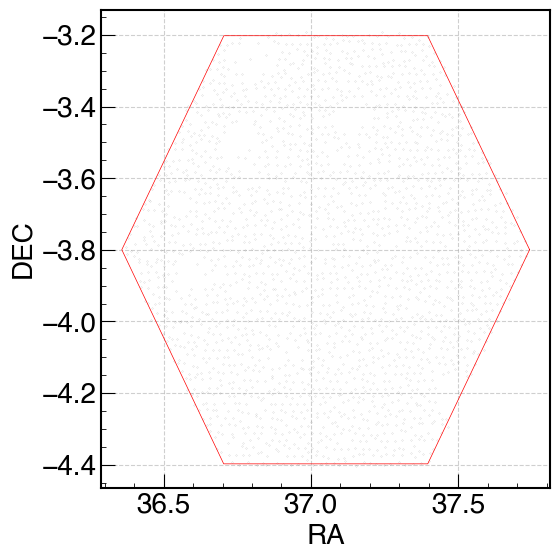

2025-02-05 21:48:24.445Z root             10 CoordTransp.py:306 0.0
2025-02-05 21:48:24.448Z root             20 DistortionCoefficients.py:688 2016.0
2025-02-05 21:48:24.451Z root             10 DistortionCoefficients.py:690 9.062970568104038 yr
2025-02-05 21:48:24.454Z root             10 DistortionCoefficients.py:701 1e-08 mas
/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
2025-02-05 21:48:24.534Z root             20 DistortionCoefficients.py:709 Ra Dec = (37.050000000000004 -3.8) : original
2025-02-05 21:48:24.543Z root             20 DistortionCoefficients.py:711 PM = (0.0 mas / yr 0.0 mas / yr)
2025-02-05 21:48:24.546Z root             20 DistortionCoefficients.py:713 Ra Dec = (37.05000000000002 -3.8) : applied proper motion
2025-02-05 21:48:24.548Z root             20 DistortionCoefficients.py:715 Ra Dec = (

Time passed - read pointings and plot for a small region: 1.06 secs
field - a, L1 (37.050000, -3.800000): 2225 targets in the FoV.


/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 2225 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
2025-02-05 21:48:24.741Z root             20 CoordTransp.py:84 Zenith angle for your field should be 30.637140255623883
2025-02-05 21:48:24.747Z root             20 CoordTransp.py:163 Correct extra distortion @ tel -- skipped
2025-02-05 21:48:24.748Z root             20 CoordTransp.py:164 Before: x= [-122.19916744 -137.3647436  -176.09796746 -195.72605342 -137.4848157
 -166.98003362 -148.21916258 -148.92748503 -174.22643984 -180.157547
 -142.93035414], y=[110.95046184  71.73554494  98.46367417  77.3445752  104.34991664
  75.29943247  70.64407357 118.65493147 111.99460232  87.50487618
  84.49351882]
2025-02-05 21:48:24.752Z root             20 CoordTransp.py:167 correct by -1.0
2025-02-05 21:48:24.758Z root             20 CoordTransp.py:170 After: x= [-122.20012944 

solving the problem for stage=0 targets.
Set parameter Presolve to value 1


2025-02-05 21:48:24.764Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-02-05 21:48:24.766Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-02-05 21:48:24.770Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-02-05 21:48:24.773Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.5


2025-02-05 21:48:24.775Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.5


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-02-05 21:48:26.055Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-02-05 21:48:26.058Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-02-05 21:48:26.059Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-02-05 21:48:26.062Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-02-05 21:48:26.065Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-02-05 21:48:26.080Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 7300 rows, 9215 columns and 17467 nonzeros


2025-02-05 21:48:26.084Z gurobipy         20 netflow.py:149 Optimize a model with 7300 rows, 9215 columns and 17467 nonzeros


Model fingerprint: 0x5db3727c


2025-02-05 21:48:26.093Z gurobipy         20 netflow.py:149 Model fingerprint: 0x5db3727c


Variable types: 1 continuous, 9214 integer (6988 binary)


2025-02-05 21:48:26.097Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 9214 integer (6988 binary)


Coefficient statistics:


2025-02-05 21:48:26.100Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-02-05 21:48:26.103Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-05, 1e+06]


2025-02-05 21:48:26.124Z gurobipy         20 netflow.py:149   Objective range  [1e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-02-05 21:48:26.130Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+03]


2025-02-05 21:48:26.132Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+03]


Found heuristic solution: objective 890000.00000


2025-02-05 21:48:26.147Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 890000.00000


Presolve removed 7300 rows and 9215 columns


2025-02-05 21:48:26.180Z gurobipy         20 netflow.py:149 Presolve removed 7300 rows and 9215 columns


Presolve time: 0.02s


2025-02-05 21:48:26.183Z gurobipy         20 netflow.py:149 Presolve time: 0.02s


Presolve: All rows and columns removed


2025-02-05 21:48:26.200Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-02-05 21:48:26.209Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.14 seconds (0.01 work units)


2025-02-05 21:48:26.212Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.14 seconds (0.01 work units)


Thread count was 1 (of 8 available processors)


2025-02-05 21:48:26.215Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-02-05 21:48:26.220Z gurobipy         20 netflow.py:149 


Solution count 2: 80.81 890000 


2025-02-05 21:48:26.226Z gurobipy         20 netflow.py:149 Solution count 2: 80.81 890000 


2025-02-05 21:48:26.229Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-01)


2025-02-05 21:48:26.230Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-01)


Best objective 8.080997540147e+01, best bound 8.080997540147e+01, gap 0.0000%


2025-02-05 21:48:26.249Z gurobipy         20 netflow.py:149 Best objective 8.080997540147e+01, best bound 8.080997540147e+01, gap 0.0000%


Checking for trajectory collisions


2025-02-05 21:48:26.349Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-02-05 21:48:26.350Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-02-05 21:48:26.480Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-02-05 21:48:26.511Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-02-05 21:48:26.514Z engineer         20 engineer.py:395 Move theta arms to angle=[234.56 193.52  52.3  ... 195.95 185.96 149.31] degree
2025-02-05 21:48:26.516Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 74.48 63.06 ...  4.19 46.96 59.16] degree
2025-02-05 21:48:26.517Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-02-05 21:48:26.522Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-02-05 21:48:26.564Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-02-05 21:48:26.593Z pfi              40 pfi.py:89

ERROR: detected 13 end point collision, which should be impossible
trajectory collisions found: 0
Done: solving the problem for stage=0 targets.
solving the problem for stage=1 targets.
Set parameter Presolve to value 1


2025-02-05 21:48:35.445Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-02-05 21:48:35.446Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-02-05 21:48:35.448Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-02-05 21:48:35.451Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.5


2025-02-05 21:48:35.454Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.5


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-02-05 21:48:36.696Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-02-05 21:48:36.699Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-02-05 21:48:36.703Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-02-05 21:48:36.705Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-02-05 21:48:36.707Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-02-05 21:48:36.730Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 9525 rows, 9215 columns and 19692 nonzeros


2025-02-05 21:48:36.732Z gurobipy         20 netflow.py:149 Optimize a model with 9525 rows, 9215 columns and 19692 nonzeros


Model fingerprint: 0x2c2a49a0


2025-02-05 21:48:36.734Z gurobipy         20 netflow.py:149 Model fingerprint: 0x2c2a49a0


Variable types: 1 continuous, 9214 integer (6988 binary)


2025-02-05 21:48:36.741Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 9214 integer (6988 binary)


Coefficient statistics:


2025-02-05 21:48:36.744Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-02-05 21:48:36.746Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-05, 1e+06]


2025-02-05 21:48:36.748Z gurobipy         20 netflow.py:149   Objective range  [1e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-02-05 21:48:36.751Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+03]


2025-02-05 21:48:36.765Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+03]


Found heuristic solution: objective 80.8099754


2025-02-05 21:48:36.774Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 80.8099754


Presolve removed 9525 rows and 9215 columns


2025-02-05 21:48:36.794Z gurobipy         20 netflow.py:149 Presolve removed 9525 rows and 9215 columns


Presolve time: 0.02s


2025-02-05 21:48:36.800Z gurobipy         20 netflow.py:149 Presolve time: 0.02s


Presolve: All rows and columns removed


2025-02-05 21:48:36.814Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-02-05 21:48:36.826Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.11 seconds (0.01 work units)


2025-02-05 21:48:36.827Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.11 seconds (0.01 work units)


Thread count was 1 (of 8 available processors)


2025-02-05 21:48:36.829Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-02-05 21:48:36.831Z gurobipy         20 netflow.py:149 


Solution count 1: 80.81 


2025-02-05 21:48:36.833Z gurobipy         20 netflow.py:149 Solution count 1: 80.81 


2025-02-05 21:48:36.843Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-01)


2025-02-05 21:48:36.847Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-01)


Best objective 8.080997540147e+01, best bound 8.080997540147e+01, gap 0.0000%


2025-02-05 21:48:36.850Z gurobipy         20 netflow.py:149 Best objective 8.080997540147e+01, best bound 8.080997540147e+01, gap 0.0000%


Checking for trajectory collisions


2025-02-05 21:48:36.965Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-02-05 21:48:36.966Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-02-05 21:48:37.098Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-02-05 21:48:37.136Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-02-05 21:48:37.140Z engineer         20 engineer.py:395 Move theta arms to angle=[234.56 193.52  52.3  ... 195.95 185.96 149.31] degree
2025-02-05 21:48:37.141Z engineer         20 engineer.py:396 Move phi arms to angle=[61.09 74.48 63.06 ...  4.19 46.96 59.16] degree
2025-02-05 21:48:37.141Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-02-05 21:48:37.142Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-02-05 21:48:37.168Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-02-05 21:48:37.193Z pfi              40 pfi.py:89

ERROR: detected 13 end point collision, which should be impossible
trajectory collisions found: 0
Done: solving the problem for stage=1 targets.
exposure 0:
  assigned Cobras: 2225
   sci_P1: 2225
exposure 0:
assigned Cobras(%): 92.94%; gal--92.94%, anc--0.00%, sky--0.00%, star--0.00%
comp_out= {'sci_P1': 1.0}
['sci_P1']


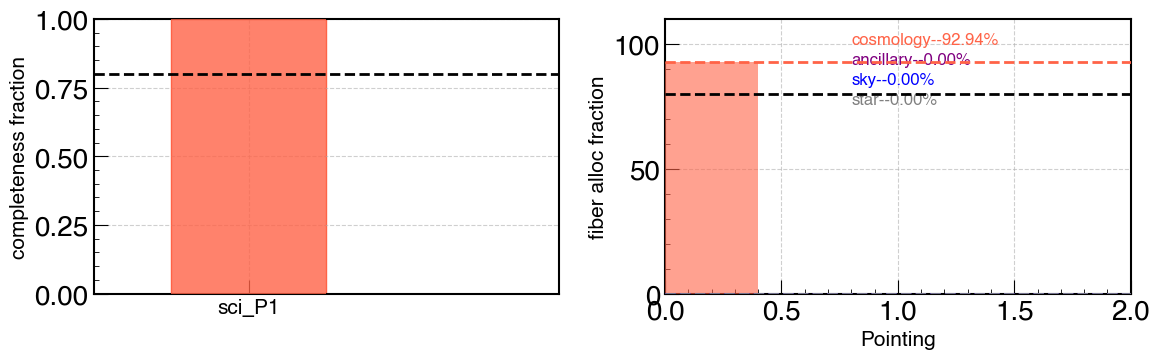

24.027752 secs passed after the visits done for field_a_L1_visit1.


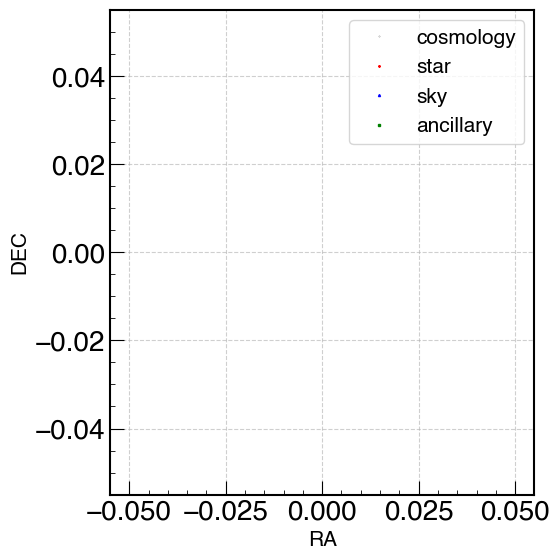

Done: field-a, Li-L1, visit-1
construct target list:
../../output/Jan25/final_nf_input/field_a_L1_visit2_final_targets.ecsv
In total, there are 2100 targets.
Time passed - construct target list: 0.15 secs
  Your sample (gray), with the pointings (red):
There are 2043 targets in the FOV centered on (37.050000, -3.800000).


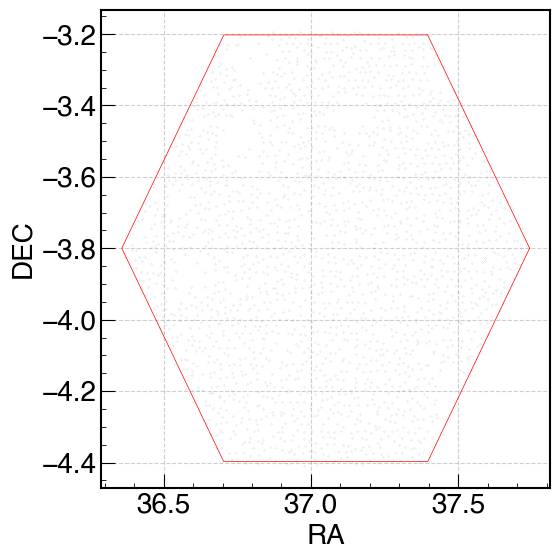

2025-02-05 21:48:49.630Z root             10 CoordTransp.py:306 0.0
2025-02-05 21:48:49.633Z root             20 DistortionCoefficients.py:688 2016.0
2025-02-05 21:48:49.635Z root             10 DistortionCoefficients.py:690 9.062970568104038 yr
2025-02-05 21:48:49.636Z root             10 DistortionCoefficients.py:701 1e-08 mas
/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 1 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
2025-02-05 21:48:49.714Z root             20 DistortionCoefficients.py:709 Ra Dec = (37.050000000000004 -3.8) : original
2025-02-05 21:48:49.721Z root             20 DistortionCoefficients.py:711 PM = (0.0 mas / yr 0.0 mas / yr)
2025-02-05 21:48:49.723Z root             20 DistortionCoefficients.py:713 Ra Dec = (37.05000000000002 -3.8) : applied proper motion
2025-02-05 21:48:49.726Z root             20 DistortionCoefficients.py:715 Ra Dec = (

Time passed - read pointings and plot for a small region: 1.07 secs
field - a, L1 (37.050000, -3.800000): 2100 targets in the FoV.


/Users/jing/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 2100 of "distance overridden (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
2025-02-05 21:48:49.894Z root             20 CoordTransp.py:84 Zenith angle for your field should be 30.637140255623883
2025-02-05 21:48:49.897Z root             20 CoordTransp.py:163 Correct extra distortion @ tel -- skipped
2025-02-05 21:48:49.898Z root             20 CoordTransp.py:164 Before: x= [   0.68385873  -97.13214104  -20.09448908 -128.26329898 -136.35535237
   71.69545436  -37.79169003  146.36193953  168.42356755  171.18252973
  127.34118939], y=[ 203.1271069   171.48702352 -189.04292724   38.10524327  -41.28010847
   25.29213954    1.36525679 -136.11139784  146.87645903  144.63475291
  158.02312801]
2025-02-05 21:48:49.902Z root             20 CoordTransp.py:167 correct by -1.0
2025-02-05 21:48:49.903Z root             20 CoordTransp.py:170 After: x= [

solving the problem for stage=0 targets.
Set parameter Presolve to value 1


2025-02-05 21:48:49.907Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-02-05 21:48:49.915Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-02-05 21:48:49.922Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-02-05 21:48:49.930Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.5


2025-02-05 21:48:49.932Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.5


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-02-05 21:48:51.173Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-02-05 21:48:51.175Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-02-05 21:48:51.178Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-02-05 21:48:51.180Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-02-05 21:48:51.183Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-02-05 21:48:51.213Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 7174 rows, 8832 columns and 17321 nonzeros


2025-02-05 21:48:51.215Z gurobipy         20 netflow.py:149 Optimize a model with 7174 rows, 8832 columns and 17321 nonzeros


Model fingerprint: 0x8a5bf2e8


2025-02-05 21:48:51.228Z gurobipy         20 netflow.py:149 Model fingerprint: 0x8a5bf2e8


Variable types: 1 continuous, 8831 integer (6730 binary)


2025-02-05 21:48:51.230Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 8831 integer (6730 binary)


Coefficient statistics:


2025-02-05 21:48:51.234Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-02-05 21:48:51.249Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-05, 1e+06]


2025-02-05 21:48:51.254Z gurobipy         20 netflow.py:149   Objective range  [1e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-02-05 21:48:51.260Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+03]


2025-02-05 21:48:51.264Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+03]


Found heuristic solution: objective 840000.00000


2025-02-05 21:48:51.273Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 840000.00000


Presolve removed 7174 rows and 8832 columns


2025-02-05 21:48:51.313Z gurobipy         20 netflow.py:149 Presolve removed 7174 rows and 8832 columns


Presolve time: 0.03s


2025-02-05 21:48:51.320Z gurobipy         20 netflow.py:149 Presolve time: 0.03s


Presolve: All rows and columns removed


2025-02-05 21:48:51.330Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-02-05 21:48:51.338Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.15 seconds (0.01 work units)


2025-02-05 21:48:51.344Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.15 seconds (0.01 work units)


Thread count was 1 (of 8 available processors)


2025-02-05 21:48:51.348Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-02-05 21:48:51.351Z gurobipy         20 netflow.py:149 


Solution count 2: 88.124 840000 


2025-02-05 21:48:51.354Z gurobipy         20 netflow.py:149 Solution count 2: 88.124 840000 


2025-02-05 21:48:51.357Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-01)


2025-02-05 21:48:51.359Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-01)


Best objective 8.812404112894e+01, best bound 8.812404112894e+01, gap 0.0000%


2025-02-05 21:48:51.363Z gurobipy         20 netflow.py:149 Best objective 8.812404112894e+01, best bound 8.812404112894e+01, gap 0.0000%


Checking for trajectory collisions


2025-02-05 21:48:51.445Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-02-05 21:48:51.446Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-02-05 21:48:51.581Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-02-05 21:48:51.608Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-02-05 21:48:51.610Z engineer         20 engineer.py:395 Move theta arms to angle=[157.75 125.79 186.88 ... 195.95 251.55 381.26] degree
2025-02-05 21:48:51.611Z engineer         20 engineer.py:396 Move phi arms to angle=[42.77 74.48 50.51 ...  4.19 61.99 59.16] degree
2025-02-05 21:48:51.612Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-02-05 21:48:51.613Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-02-05 21:48:51.637Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-02-05 21:48:51.662Z pfi              40 pfi.py:89

ERROR: detected 13 end point collision, which should be impossible
trajectory collisions found: 0
Done: solving the problem for stage=0 targets.
solving the problem for stage=1 targets.
Set parameter Presolve to value 1


2025-02-05 21:49:01.283Z gurobipy         20 netflow.py:117 Set parameter Presolve to value 1


Set parameter Method to value 4


2025-02-05 21:49:01.296Z gurobipy         20 netflow.py:117 Set parameter Method to value 4


Set parameter DegenMoves to value 0


2025-02-05 21:49:01.424Z gurobipy         20 netflow.py:117 Set parameter DegenMoves to value 0


Set parameter Heuristics to value 0.8


2025-02-05 21:49:01.431Z gurobipy         20 netflow.py:117 Set parameter Heuristics to value 0.8


Set parameter MIPGap to value 0.5


2025-02-05 21:49:01.434Z gurobipy         20 netflow.py:117 Set parameter MIPGap to value 0.5


Creating network topology
  exposure 1
Calculating visibilities
adding constraints
adding collision constraints
adding forbidden pair constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-02-05 21:49:02.617Z gurobipy         20 netflow.py:149 Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])


2025-02-05 21:49:02.621Z gurobipy         20 netflow.py:149 


CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


2025-02-05 21:49:02.623Z gurobipy         20 netflow.py:149 CPU model: Intel(R) Core(TM) i7-8569U CPU @ 2.80GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-02-05 21:49:02.625Z gurobipy         20 netflow.py:149 Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


2025-02-05 21:49:02.627Z gurobipy         20 netflow.py:149 


Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


2025-02-05 21:49:02.637Z gurobipy         20 netflow.py:149 Academic license 2379863 - for non-commercial use only - registered to ji___@ipmu.jp


Optimize a model with 9274 rows, 8832 columns and 19421 nonzeros


2025-02-05 21:49:02.640Z gurobipy         20 netflow.py:149 Optimize a model with 9274 rows, 8832 columns and 19421 nonzeros


Model fingerprint: 0x2fb23e4e


2025-02-05 21:49:02.644Z gurobipy         20 netflow.py:149 Model fingerprint: 0x2fb23e4e


Variable types: 1 continuous, 8831 integer (6730 binary)


2025-02-05 21:49:02.656Z gurobipy         20 netflow.py:149 Variable types: 1 continuous, 8831 integer (6730 binary)


Coefficient statistics:


2025-02-05 21:49:02.660Z gurobipy         20 netflow.py:149 Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


2025-02-05 21:49:02.663Z gurobipy         20 netflow.py:149   Matrix range     [1e+00, 1e+00]


  Objective range  [1e-05, 1e+06]


2025-02-05 21:49:02.666Z gurobipy         20 netflow.py:149   Objective range  [1e-05, 1e+06]


  Bounds range     [1e+00, 1e+00]


2025-02-05 21:49:02.671Z gurobipy         20 netflow.py:149   Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 2e+03]


2025-02-05 21:49:02.677Z gurobipy         20 netflow.py:149   RHS range        [1e+00, 2e+03]


Found heuristic solution: objective 88.1240411


2025-02-05 21:49:02.688Z gurobipy         20 netflow.py:149 Found heuristic solution: objective 88.1240411


Presolve removed 9274 rows and 8832 columns


2025-02-05 21:49:02.707Z gurobipy         20 netflow.py:149 Presolve removed 9274 rows and 8832 columns


Presolve time: 0.02s


2025-02-05 21:49:02.711Z gurobipy         20 netflow.py:149 Presolve time: 0.02s


Presolve: All rows and columns removed


2025-02-05 21:49:02.719Z gurobipy         20 netflow.py:149 Presolve: All rows and columns removed


2025-02-05 21:49:02.724Z gurobipy         20 netflow.py:149 


Explored 0 nodes (0 simplex iterations) in 0.09 seconds (0.01 work units)


2025-02-05 21:49:02.733Z gurobipy         20 netflow.py:149 Explored 0 nodes (0 simplex iterations) in 0.09 seconds (0.01 work units)


Thread count was 1 (of 8 available processors)


2025-02-05 21:49:02.738Z gurobipy         20 netflow.py:149 Thread count was 1 (of 8 available processors)


2025-02-05 21:49:02.743Z gurobipy         20 netflow.py:149 


Solution count 1: 88.124 


2025-02-05 21:49:02.747Z gurobipy         20 netflow.py:149 Solution count 1: 88.124 


2025-02-05 21:49:02.749Z gurobipy         20 netflow.py:149 


Optimal solution found (tolerance 5.00e-01)


2025-02-05 21:49:02.755Z gurobipy         20 netflow.py:149 Optimal solution found (tolerance 5.00e-01)


Best objective 8.812404112894e+01, best bound 8.812404112894e+01, gap 0.0000%


2025-02-05 21:49:02.763Z gurobipy         20 netflow.py:149 Best objective 8.812404112894e+01, best bound 8.812404112894e+01, gap 0.0000%


Checking for trajectory collisions


2025-02-05 21:49:02.850Z pfi              40 pfi.py:896 Some theta angles are out of range
2025-02-05 21:49:02.851Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-02-05 21:49:02.995Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-02-05 21:49:03.034Z pfi              40 pfi.py:899 Some phi angles are out of range
2025-02-05 21:49:03.038Z engineer         20 engineer.py:395 Move theta arms to angle=[157.75 125.79 186.88 ... 195.95 251.55 381.26] degree
2025-02-05 21:49:03.039Z engineer         20 engineer.py:396 Move phi arms to angle=[42.77 74.48 50.51 ...  4.19 61.99 59.16] degree
2025-02-05 21:49:03.040Z engineer         20 engineer.py:398 Checking passed homed argument = True
2025-02-05 21:49:03.043Z engineer         20 engineer.py:402 Move theta arms CW and phi arms CCW to the hard stops
2025-02-05 21:49:03.070Z cobraCoach       20 cobraCoach.py:1065 home cobras: theta=10000, phi=-5000
2025-02-05 21:49:03.093Z pfi              40 pfi.py:89

ERROR: detected 13 end point collision, which should be impossible
trajectory collisions found: 0
Done: solving the problem for stage=1 targets.
exposure 0:
  assigned Cobras: 2100
   sci_P1: 2100
exposure 0:
assigned Cobras(%): 87.72%; gal--87.72%, anc--0.00%, sky--0.00%, star--0.00%
comp_out= {'sci_P1': 1.0}
['sci_P1']


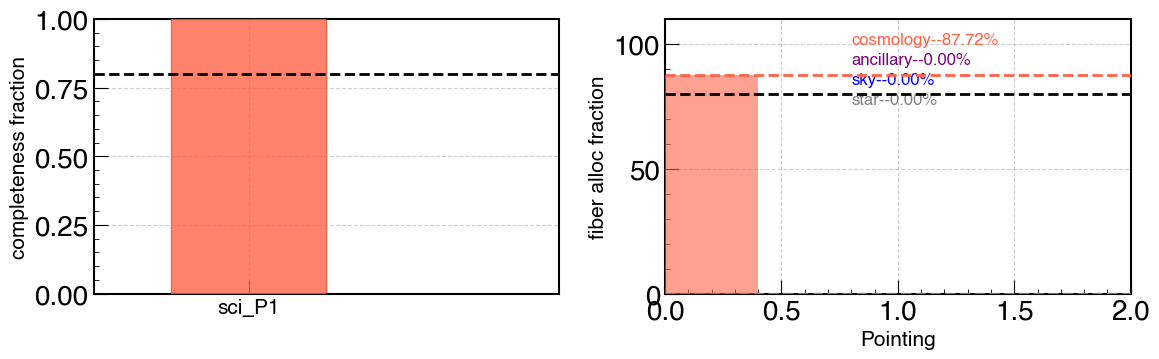

23.709391 secs passed after the visits done for field_a_L1_visit2.


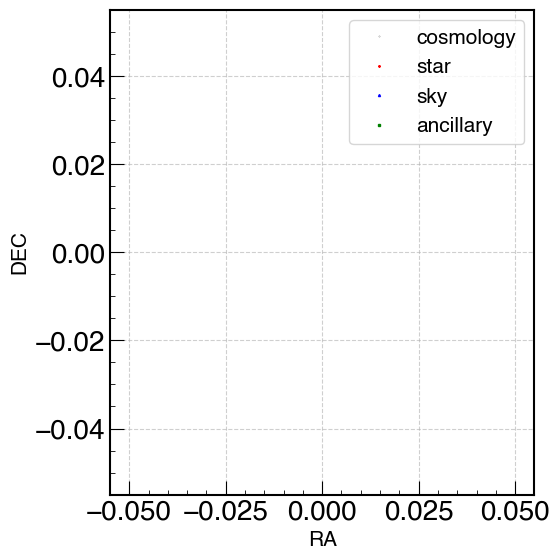

Done: field-a, Li-L1, visit-2


In [14]:
outdir = '../../output/Jan25/Jan25_test/'
data_dir = '../../output/Jan25/final_nf_input/'
prefix = ''

# NOTE: need the data w/o updated AlreadyObserved column to run for each field visit 1

# SOLUTION for netflow run failure of some pointings: 
# shift centers by ra - 0.05, P2 targets number/3., change mipgap to 0.5;

# default -- gurobiOptions = dict(seed=0, presolve=1, method=4, degenmoves=0, heuristics=0.8, mipfocus=0, mipgap=5.e-2, LogToConsole=1)
gurobiOptions = dict(seed=0, presolve=1, method=4, degenmoves=0, heuristics=0.8, mipfocus=0, mipgap=5.e-1, LogToConsole=1)

# HST(UTC-10) Jan 22 20:00 for field a and b, same for both visits
otime_list = ['2025-01-23T06:00:00Z', '2025-01-23T06:00:00Z', '2025-01-23T09:00:00Z']

#for field, Li_list, otime in zip(['a', 'b', 'e'], [['L1', 'L3', 'L4'], ['L1', 'L2', 'L3'], ['L1', 'L2', 'L3', 'L4']], otime_list):
for field, Li_list, otime in zip(['a',], [['L1', ], ], ['2025-01-23T06:00:00Z', ]):
    pointings_list = ascii.read('../../output/Jan25/final/' + 'field_{}_pointings.csv'.format(field))
    print(pointings_list)

    # telescope parameters
    tele_params = {"otime": otime, "posang":0.}
    for Li, pointings in zip(Li_list, pointings_list):
        for visit in [1, 2]:
            # cosmology + sky + star targets
            #fn_list = ['field_{}_targets.ecsv'.format(field), 'star_field_{}_targets.ecsv'.format(field), 'sky_field_{}_targets.ecsv'.format(field)]
            #prefix_list = ["sci", "cal", "sky"]
            #calibration_list = [False, True, True]
            #field_a_L1_visit1_final_targets.ecsv
            fn_list = ['field_{}_{}_visit{}_final_targets.ecsv'.format(field, Li, visit)]
            prefix_list = ["sci", ]
            calibration_list = [False, ]
            
            simulator = main(outdir, data_dir, False, pointings, prefix, field, [Li, ], visit, \
                  fn_list, prefix_list, calibration_list, tele_params, bench, cobracoach, \
                  two_stage=True, gurobiOptions=gurobiOptions, collision_sim_version=2)
            
            print("Done: field-%s, Li-%s, visit-%d" % (field, Li, visit))
    
    
    

# check list for the observatory Target Uploader
+ CO netflow output targets all get a fiber assigned (test myself - use output as an input, all targets have the same cost)
+ two stage == different cost (same sky coverage)?
+ CO needs to track the status of the target list and instrument
+ if different otime is used, how many targets (sci, sky, star separately) will be missed? (test myself - use output as an input)

In [29]:
goodIdx = cobracoach.goodIdx
goodindex = np.where(simulator.goodCobras == True)[0]
assert np.all(goodIdx == goodindex)

print(np.max(goodIdx), np.max(goodindex))

2393 2393


array([   0,    1,    2, ..., 2390, 2391, 2392])

In [19]:
cobracoach.allCobras

array([<ics.cobraCharmer.func.Cobra object at 0x7fdce02d1180>,
       <ics.cobraCharmer.func.Cobra object at 0x7fdce3447e50>, ...,
      dtype=object)

In [16]:
print("bad cobras: ", np.where(simulator.goodCobras == False)[0])
cobras_bad = np.where(simulator.goodCobras == False)[0]
len(cobras_bad)

bad cobras:  [  46   49  172  192  346  360  647  753  798  820  852  948 1149 1172
 1207 1209 1519 1579 1652 1723 1790 1824 1835 1881 1902 2052 2181 2351
 2379]


29